## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 32.8 s, sys: 195 ms, total: 33 s
Wall time: 33.3 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_4'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Wed Jan 22 22:06:29 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


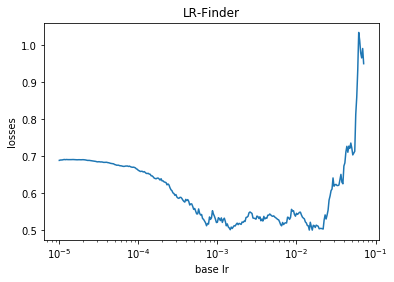

Starting inference for model: checkpoints/siamese_bert_4_fold_1_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_1_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_1_epoch_3.pth



Averaged Val. score: 0.422464481233006
Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Fold 2 started at Wed Jan 22 22:09:00 2020
Starting inference for model: checkpoints/siamese_bert_4_fold_2_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_2_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_2_epoch_3.pth



Averaged Val. score: 0.4190368447155895
Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Fold 3 started at Wed Jan 22 22:10:28 2020
Starting inference for model: checkpoints/siamese_bert_4_fold_3_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_3_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_3_epoch_3.pth



Averaged Val. score: 0.39853469145731957
Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Fold 4 started at Wed Jan 22 22:11:55 2020
Starting inference for model: checkpoints/siamese_bert_4_fold_4_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_4_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_4_epoch_3.pth



Averaged Val. score: 0.4002783910711324
Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Fold 5 started at Wed Jan 22 22:13:23 2020
Starting inference for model: checkpoints/siamese_bert_4_fold_5_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_5_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_5_epoch_3.pth



Averaged Val. score: 0.4068504111334144
Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Fold 6 started at Wed Jan 22 22:14:51 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50917 - spearmanr 0.24773
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4627 - spearmanr 0.37531
best model: epoch 0 - 0.37531
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4568 - spearmanr 0.3968
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45894 - spearmanr 0.38184
best model: epoch 1 - 0.38184
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43263 - spearmanr 0.4608
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45251 - spearmanr 0.39485
best model: epoch 2 - 0.39485
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41118 - spearmanr 0.51384
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4537 - spearmanr 0.39291
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39485
Starting inference for model: checkpoints/siamese_bert_4_fold_6_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_6_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_6_epoch_3.pth



Averaged Val. score: 0.39697916386614096
Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Fold 7 started at Wed Jan 22 22:55:23 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50799 - spearmanr 0.24952
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47499 - spearmanr 0.37323
best model: epoch 0 - 0.37323
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45673 - spearmanr 0.39318
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45736 - spearmanr 0.41002
best model: epoch 1 - 0.41002
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4321 - spearmanr 0.45894
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45916 - spearmanr 0.4135
best model: epoch 2 - 0.4135
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41021 - spearmanr 0.51381
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4598 - spearmanr 0.4141
best model: epoch 3 - 0.4141
TRAINING END: Best score achieved on epoch 3 - 0.41410
Starting inference for model: checkpoints/siamese_bert_4_fold_7_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_7_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_7_epoch_3.pth



Averaged Val. score: 0.4172563177770672
Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Fold 8 started at Wed Jan 22 23:35:47 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50894 - spearmanr 0.24643
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47778 - spearmanr 0.37873
best model: epoch 0 - 0.37873
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45576 - spearmanr 0.39472
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46174 - spearmanr 0.41196
best model: epoch 1 - 0.41196
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43239 - spearmanr 0.45824
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46075 - spearmanr 0.413
best model: epoch 2 - 0.413
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41065 - spearmanr 0.51188
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46739 - spearmanr 0.41221
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41300
Starting inference for model: checkpoints/siamese_bert_4_fold_8_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_8_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_8_epoch_3.pth



Averaged Val. score: 0.4167884996481433
Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Fold 9 started at Thu Jan 23 00:15:17 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50921 - spearmanr 0.24565
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47053 - spearmanr 0.35948
best model: epoch 0 - 0.35948
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45612 - spearmanr 0.39666
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45604 - spearmanr 0.39785
best model: epoch 1 - 0.39785
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43183 - spearmanr 0.46189
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45492 - spearmanr 0.40483
best model: epoch 2 - 0.40483
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41025 - spearmanr 0.5153
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45829 - spearmanr 0.40373
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40483
Starting inference for model: checkpoints/siamese_bert_4_fold_9_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_9_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_9_epoch_3.pth



Averaged Val. score: 0.4062959560463029
Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Fold 10 started at Thu Jan 23 00:54:45 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50935 - spearmanr 0.24542
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4613 - spearmanr 0.38525
best model: epoch 0 - 0.38525
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45715 - spearmanr 0.39631
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44577 - spearmanr 0.42002
best model: epoch 1 - 0.42002
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43328 - spearmanr 0.45877
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44424 - spearmanr 0.42284
best model: epoch 2 - 0.42284
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41079 - spearmanr 0.51465
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44632 - spearmanr 0.42221
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42284
Starting inference for model: checkpoints/siamese_bert_4_fold_10_epoch_1.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_10_epoch_2.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_10_epoch_3.pth



Averaged Val. score: 0.4272308295026128
Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



OOF score: 0.41091469044055295


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True,
        n_top_models=5
    )
    if (fold_id + 1) > 5: learner.train()
    
    oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(1), device) / 3
    oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(2), device) / 3
    oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(3), device) / 3
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [12]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

def ahmet_round(preds, ds, indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

In [13]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.35296961883572653
0 10 0.37848158420557804
0 15 0.383047497008554
0 None 0.38367351970376884
1 5 0.6495106231251916
1 10 0.6636087480773116
1 15 0.6654698865806958
1 20 0.6658262226795929
1 33 0.6668224693040077
2 5 0.48890661961126564
3 5 0.2819315941562942
3 10 0.2946968291611203
3 15 0.30182997282463553
3 33 0.3030709566097796
3 None 0.3033575486838583
4 5 0.35573788444695287
4 15 0.3583943954809704
5 5 0.4486562696842933
6 5 0.32127500617151117
6 10 0.3494175525729574
6 15 0.35529266864601944
6 33 0.3571124139223401
7 5 0.5078062177119642
7 10 0.5122485883990013
7 33 0.5127565260652561
7 None 0.5127957224649092
8 5 0.576077178668851
8 10 0.5783384680003121
8 20 0.5787243371441678
9 10 0.06057425224454802
9 15 0.08979406702855658
9 20 0.10675210537656973
9 33 0.1188637407192588
10 5 0.45800365155041267
10 10 0.4713334794906565
10 15 0.4729412704664233
11 5 0.7475603700993587
11 10 0.7501264200543546
12 5 0.5102289713743053
13 5 0.19789534355426666
13 10 0.22850486756383814
13 

In [28]:
np.array(opt_ds), np.array(opt_indices)

(array([33,  5, 15,  5, 33, 20, 33, 15, 10,  5, 20, 10,  5, 15, 20, 10, 20,
        20, 33, 33, 33]),
 array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 23,
        25, 26, 27, 29]))

In [15]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.44966508363429947

In [16]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.44966508363429947

In [17]:
spearmanr_np(oofs, y)

0.41091469044055295

In [18]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.4224543116568158

In [19]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [20]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.820128,0.560491,0.287655,0.392382,0.556220,0.415504,0.684707,0.705357,0.737442,0.004511,0.699351,0.791062,0.023480,0.433926,0.006390,0.019275,0.097979,0.167859,0.781745,0.000574,0.809896,0.574970,0.185562,0.741421,0.721458,0.307480,0.024030,0.039609,0.790241,0.601988
1,46,0.457425,0.276422,0.009365,0.673220,0.632151,0.865561,0.414767,0.354307,0.045207,0.017440,0.483384,0.225443,0.003711,0.000447,0.000723,0.011980,0.895310,0.320857,0.070142,0.000105,0.222240,0.748567,0.474121,0.859028,0.923253,0.571277,0.943385,0.219972,0.038276,0.588884
2,70,0.681723,0.521730,0.033955,0.643189,0.816742,0.903828,0.511296,0.425606,0.303703,0.005011,0.299266,0.721327,0.025606,0.054118,0.001961,0.007164,0.155803,0.144926,0.762992,0.000767,0.637243,0.655138,0.308473,0.841519,0.839417,0.482044,0.054672,0.064818,0.840877,0.536865
3,132,0.574080,0.171395,0.004386,0.618407,0.633731,0.877567,0.384812,0.236057,0.152763,0.009837,0.592906,0.107932,0.001555,0.002178,0.000288,0.002205,0.825233,0.299557,0.591881,0.000047,0.418133,0.805226,0.586232,0.873680,0.921676,0.642043,0.847829,0.315526,0.624869,0.664094
4,200,0.788834,0.283893,0.042986,0.802276,0.723305,0.874508,0.682778,0.713387,0.187189,0.035344,0.348660,0.561454,0.008500,0.020048,0.009132,0.069557,0.182958,0.194185,0.576088,0.003612,0.351343,0.735148,0.557417,0.875243,0.871026,0.639621,0.238881,0.233030,0.699992,0.609612


In [21]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [22]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.819595,0.639579,0.263240,0.589421,0.530881,0.406738,0.582867,0.532059,0.404028,0.006791,0.744295,0.392241,0.455591,0.080745,0.024740,0.189891,0.206507,0.157799,0.546703,0.003048,0.759051,0.868334,0.614542,0.934817,0.895309,0.711695,0.114217,0.111051,0.875609,0.721798
1,0.859253,0.754978,0.076540,0.524448,0.885525,0.677164,0.504542,0.565868,0.266925,0.002876,0.329680,0.095014,0.848162,0.009183,0.526633,0.041029,0.051917,0.055095,0.415311,0.003292,0.761662,0.584908,0.276745,0.745372,0.762314,0.354596,0.022926,0.031003,0.595727,0.767881
2,0.654542,0.242976,0.011073,0.754831,0.797478,0.829298,0.520778,0.350256,0.184130,0.002971,0.383814,0.294947,0.011164,0.003806,0.002344,0.382166,0.616658,0.246100,0.170863,0.000333,0.542536,0.790793,0.550363,0.854095,0.825887,0.627947,0.532021,0.268538,0.489469,0.715891
3,0.730720,0.674145,0.378921,0.678204,0.635264,0.715704,0.637054,0.672766,0.225441,0.003030,0.363696,0.914138,0.017846,0.020822,0.027450,0.056905,0.025777,0.157680,0.527763,0.001477,0.835460,0.743442,0.764190,0.820408,0.885760,0.734944,0.073816,0.227574,0.865283,0.756288
4,0.794276,0.678416,0.008947,0.655890,0.797530,0.870809,0.500026,0.498349,0.245645,0.003204,0.319569,0.603362,0.003757,0.003189,0.003497,0.012273,0.824853,0.308137,0.196428,0.000673,0.829414,0.660486,0.400382,0.766230,0.825789,0.520537,0.882534,0.256316,0.049932,0.583425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.861869,0.387442,0.235679,0.786579,0.620402,0.602809,0.677969,0.712858,0.505186,0.006462,0.654348,0.889965,0.219393,0.156502,0.017660,0.236184,0.026001,0.056814,0.512756,0.003331,0.640428,0.832966,0.681123,0.932168,0.888246,0.695311,0.064336,0.074855,0.855547,0.740704
6075,0.888738,0.490649,0.161765,0.596217,0.456696,0.301286,0.779384,0.794718,0.069193,0.010865,0.824910,0.009438,0.018458,0.015245,0.001136,0.031501,0.741051,0.372981,0.266446,0.000479,0.775443,0.743500,0.585517,0.861810,0.888675,0.557573,0.719068,0.310671,0.430161,0.833887
6076,0.666229,0.280985,0.002845,0.700776,0.733498,0.907978,0.423702,0.281151,0.136161,0.003741,0.486556,0.428875,0.001094,0.000443,0.000526,0.001789,0.857503,0.400227,0.222501,0.000025,0.337847,0.512064,0.337467,0.779085,0.800211,0.343189,0.561734,0.183946,0.442993,0.251579
6077,0.789496,0.511904,0.572329,0.286649,0.320539,0.179465,0.608923,0.716057,0.787554,0.003048,0.883565,0.644290,0.144031,0.050780,0.012267,0.086192,0.054658,0.211376,0.742478,0.000960,0.839568,0.678729,0.419282,0.817473,0.810770,0.505147,0.028396,0.100121,0.828050,0.786571


In [23]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.383674
question_body_critical                   0.666740
question_conversational                  0.416526
question_expect_short_answer             0.303358
question_fact_seeking                    0.357231
question_has_commonly_accepted_answer    0.435511
question_interestingness_others          0.357028
question_interestingness_self            0.512796
question_multi_intent                    0.578380
question_not_really_a_question           0.093471
question_opinion_seeking                 0.471317
question_type_choice                     0.739424
question_type_compare                    0.353946
question_type_consequence                0.178733
question_type_definition                 0.362440
question_type_entity                     0.443067
question_type_instructions               0.779541
question_type_procedure                  0.353955
question_type_reason_explanation         0.668413
question_type_spelling                   0.069009


In [24]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.069009,3.0
question_not_really_a_question,0.093471,5.0
answer_plausible,0.135642,9.0
answer_relevance,0.159215,9.0
question_type_consequence,0.178733,5.0
answer_well_written,0.230031,9.0
answer_helpful,0.238033,9.0
question_expect_short_answer,0.303358,5.0
answer_type_procedure,0.306625,5.0
answer_satisfaction,0.330213,17.0


In [25]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

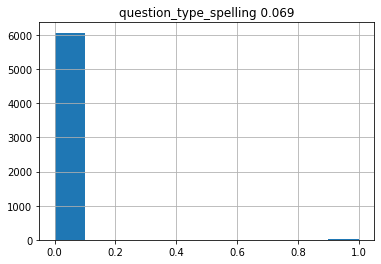

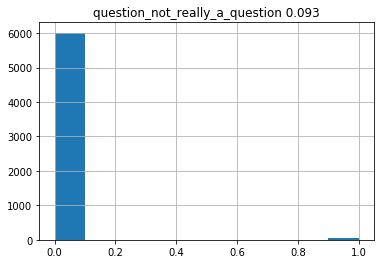

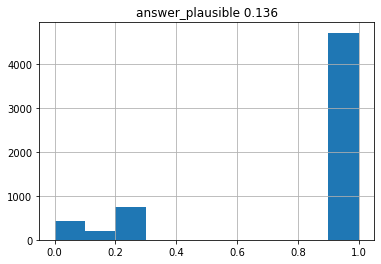

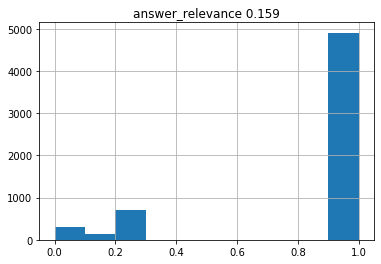

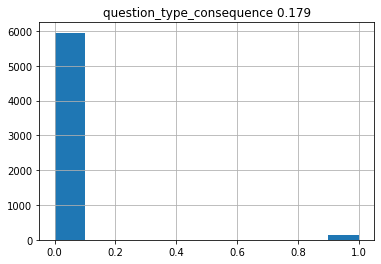

In [26]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


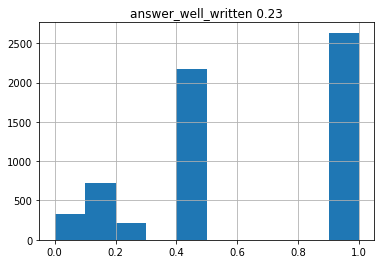

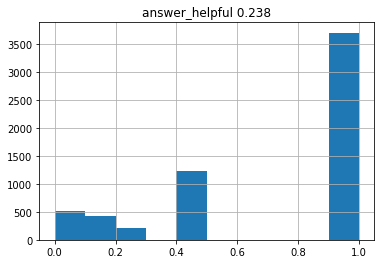

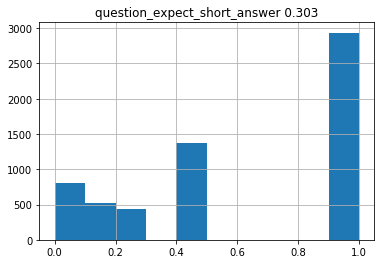

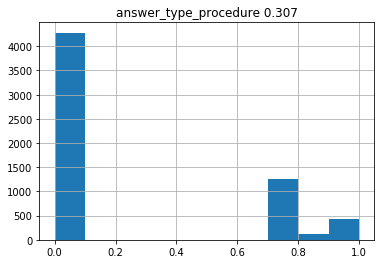

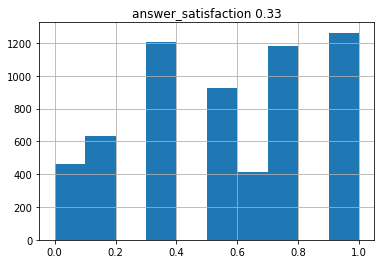

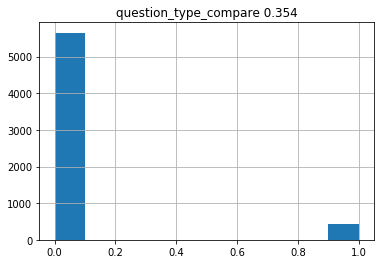

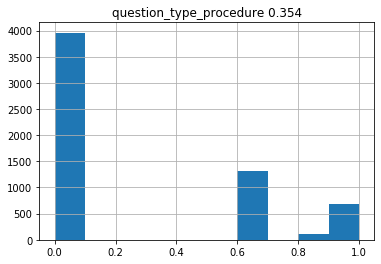

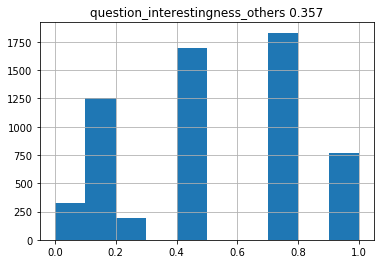

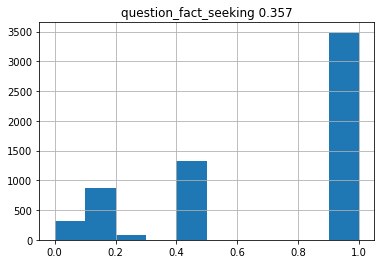

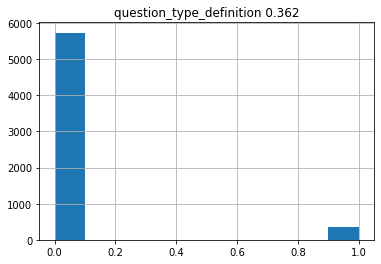

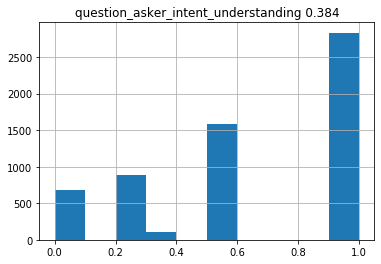

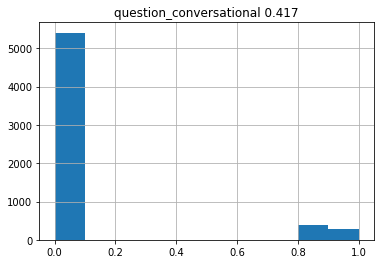

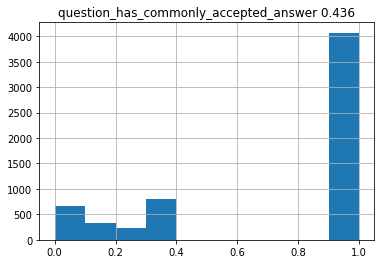

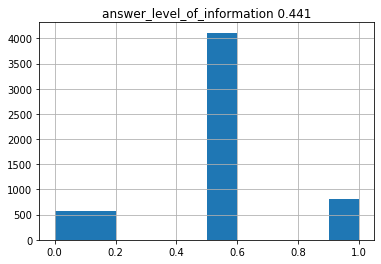

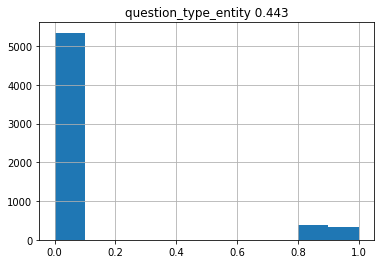

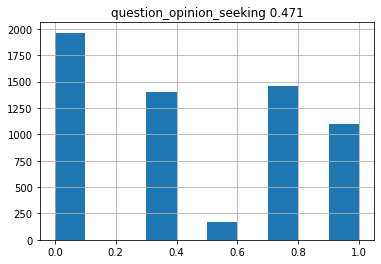

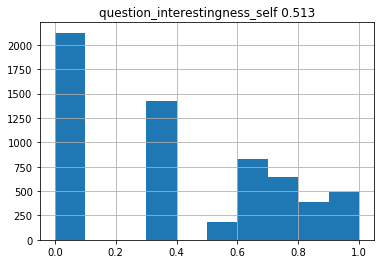

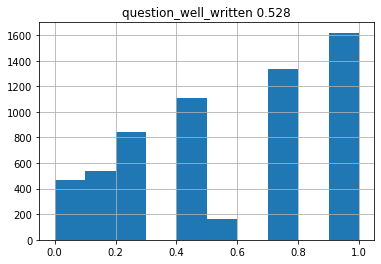

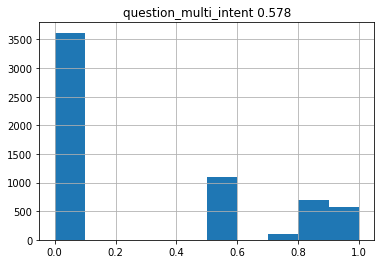

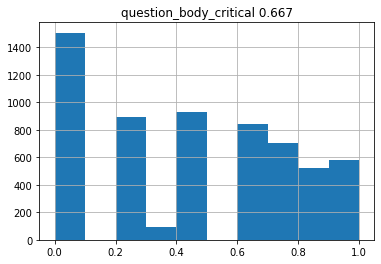

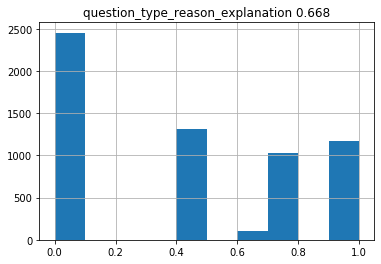

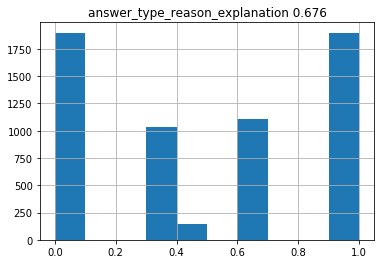

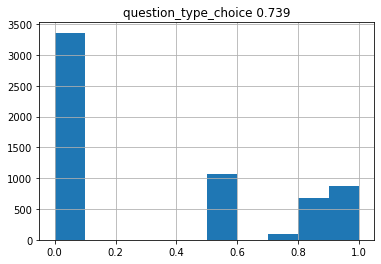

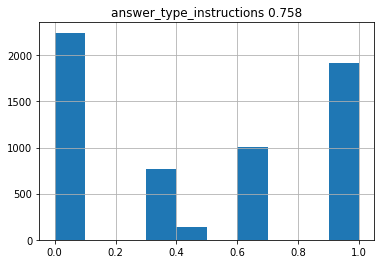

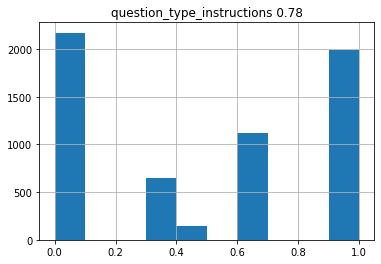

In [27]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')